# CS 342 Final Project - Letter Recognition CNN

Mrityunjay Mishra (eid: mm94424), Mihir Suvarna (eid: mms5776), Daniel Sialm (eid: dhs833)

## Project Description

This project aims to create a convolutional neural network (CNN) for the task of letter recognition. The task of letter recognition, or more generally speaking, text recognition (also known as optical character recognition, or OCR) has gained much importance in recent years due to emerging applications. For example, OCR software can be used to convert handwritten text into digital text and robots use cameras to read signs in their environment. Letter recognition is a subtask of text recognition with wide applications as well - iPhones use letter recognition to convert handwritten characters to text. Due to the increasing importance of these tasks, we aim to create a robust CNN that is able to correctly classify handwritten and digital letters.

In [1]:
# Run these two blocks to load important libraries and set things up
from letter_recognition_functions import *
from ttf_to_png import *
%matplotlib inline

## Dataset

We collected handwritten letters from 23 students, each of whom wrote the alphabet 10 times. This gave us about 6K data points to train and test our model.

In [2]:
letter_to_label = dict()
classes = ['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
for i in range(len(classes)):
    letter_to_label[classes[i]] = i
print(letter_to_label)

{'N/A': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [3]:
src_dir = 'data/collected_ttfs'
dst_dir = 'data/collected_letters_pngs'
num_ttfs = convert_ttf(src_dir, dst_dir)

Images already processed. Exiting conversion


In [4]:
src_dir = 'data/collected_letters_pngs'
transform = transforms.ToTensor()

num_train = int(0.7 * num_ttfs)
num_val = (num_ttfs - num_train) // 2

imgs_train = []
imgs_val = []
imgs_test = []
labels_train = []
labels_val = []
labels_test = []
for f in glob.glob(os.path.join(src_dir, '*.png')):
    ftitle, fext = os.path.splitext(os.path.basename(f))
    letter = ftitle.split("_")[1]
    # gets which person wrote this font
    p_val = int(ftitle.split("_")[0].split("-")[0][1:])
    im = Image.open(f).convert('L')
    
    if p_val <= num_train:
        imgs_train += transform(im).detach().tolist()
        labels_train.append(letter_to_label[letter])
    elif p_val <= num_train + num_val:
        imgs_val += transform(im).detach().tolist()
        labels_val.append(letter_to_label[letter])
    else:
        imgs_test += transform(im).detach().tolist()
        labels_test.append(letter_to_label[letter])

In [5]:
train_loader_collected = create_loader(imgs_train, labels_train)
val_loader_collected = create_loader(imgs_val, labels_val)
test_loader_collected = create_loader(imgs_test, labels_test)

Label: z


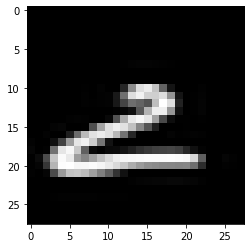

In [6]:
# Visualization for our collected dataset
img, label = get_input(train_loader_collected)
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

## Defining a basic LetterCNN

We define a basic CNN with 1 convolutional layer, 1 MaxPool layer, a ReLU activation and finally a fully connected layer for our model. This model will be used throughout our prelimenary expriments (i.e. before our computational experiments).

In [7]:
class letterCNN(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, len(self.classes))
        )
            
    def forward(self, x):
        output = self.layers(x)
        return output

## Testing the basic LetterCNN

In [8]:
basic_model_collected = letterCNN(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(basic_model_collected.parameters(), lr=1e-3)
train_network(basic_model_collected, train_loader_collected, val_loader_collected, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 3.26957
   Val loss: 3.19777

EPOCH 1
 Train loss: 3.08610
   Val loss: 3.02704

EPOCH 2
 Train loss: 2.80063
   Val loss: 2.76416

EPOCH 3
 Train loss: 2.39866
   Val loss: 2.47832

EPOCH 4
 Train loss: 1.99669
   Val loss: 2.27522

EPOCH 5
 Train loss: 1.68933
   Val loss: 2.03563

EPOCH 6
 Train loss: 1.48094
   Val loss: 1.88421

EPOCH 7
 Train loss: 1.33781
   Val loss: 2.07013

EPOCH 8
 Train loss: 1.22378
   Val loss: 1.80576

EPOCH 9
 Train loss: 1.13727
   Val loss: 1.97405



Test accuracy: 48.077


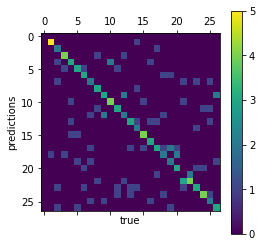

In [9]:
acc, true, pred = test_network(basic_model_collected, test_loader_collected)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(basic_model_collected.classes), pred, true)

We see quite a bit of overfitting (since the validation loss is not converging and, in fact, even increasing). This naturally causes our accuracy to be quite low. While this accuracy is still quite good - $48.718 / (1 / 26) = 12.67$ times increase in accuracy from just taking a random guess - we can still do better. The reason for this poor performance is because only a few people's data was obtained. This causes our model to be biased towards the the handwriting of a few people and prevents it from generalizing well. Thus, we will combine our dataset with the EMNIST dataset to create a better model.

## EMNIST Dataset

In [10]:
# Download the EMNIST dataset and load it as tensors
from torchvision import datasets, transforms

save_dir = 'EMNIST'

transform = transforms.ToTensor() # Convert the image into a torch tensor.

train_set = datasets.EMNIST(save_dir, split="letters", download=True, train=True, transform=transform)
test_set = datasets.EMNIST(save_dir, split="letters", download=True, train=False, transform=transform)

print(train_set)
print(test_set)

Dataset EMNIST
    Number of datapoints: 124800
    Root location: EMNIST
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset EMNIST
    Number of datapoints: 20800
    Root location: EMNIST
    Split: Test
    StandardTransform
Transform: ToTensor()


In [11]:
# Create samplers for the training and validation sets
from torch.utils.data.sampler import SubsetRandomSampler

ntotal = 60000
ntrain = int(0.70*ntotal)
nval = ntotal - ntrain

val_ix = np.random.choice(range(ntotal), size=nval, replace=False)
train_ix = list(set(range(ntotal)) - set(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

In [12]:
# initialize the data sets
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

Label: f


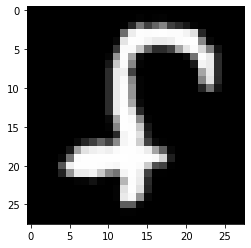

In [13]:
# Visualization EMNIST
img, label = get_input(train_loader)
# print label
index = 0
plt.imshow(img.reshape((28, 28)).T, cmap='Greys_r')
print("Label: %s" % classes[label])

## Combining EMNIST with our Data

In [14]:
combined_train_loader = combine_loaders(train_loader, train_loader_collected, fromEMNIST=True)
combined_val_loader = combine_loaders(val_loader, val_loader_collected, fromEMNIST=True)
combined_test_loader = combine_loaders(test_loader, test_loader_collected, fromEMNIST=True)

Label: v


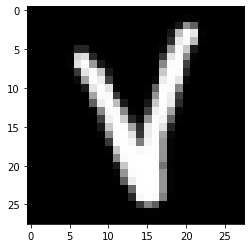

In [15]:
# Verifying combined
img, label = get_input(combined_test_loader)
# print label
index = 0
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

## Making a new LetterCNN on the Combined Dataset

In [16]:
basic_model = letterCNN(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(basic_model.parameters(), lr=1e-3)
train_network(basic_model, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.13290
   Val loss: 0.76607

EPOCH 1
 Train loss: 0.64835
   Val loss: 0.55855

EPOCH 2
 Train loss: 0.52038
   Val loss: 0.49425

EPOCH 3
 Train loss: 0.46164
   Val loss: 0.45626

EPOCH 4
 Train loss: 0.42022
   Val loss: 0.43837

EPOCH 5
 Train loss: 0.39254
   Val loss: 0.43683

EPOCH 6
 Train loss: 0.37066
   Val loss: 0.42511

EPOCH 7
 Train loss: 0.35193
   Val loss: 0.41854

EPOCH 8
 Train loss: 0.33631
   Val loss: 0.41535

EPOCH 9
 Train loss: 0.32308
   Val loss: 0.41951



Test accuracy: 87.445


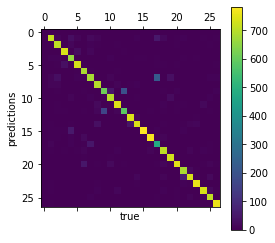

In [17]:
acc, true, pred = test_network(basic_model, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(basic_model.classes), pred, true)

We see immediate improvement in our results. The new model does not overfit (since the validation loss decreases) and generalizes quite well, giving us an accuracy of about 86%, an increase of about 79% in accuracy compared to our older model. This shows that our model works well if a good dataset is provided. 

## Computational Experiment 1 - Regularization

Our first set of computational experiments will deal with better regularization of our model in hopes of creating a more generalized model. 

### 1a) Regularization through data augmentation - add digital fonts

For this experiment, we add digital fonts to our dataset. Specifically, we take about 100 different fonts and add their characters to our dataset. We hypothesize that this will increase the accuracy of our model.

In [18]:
src_dir = 'data/digital_ttfs'
dst_dir = 'data/digital_letters_pngs'
num_ttfs = convert_ttf(src_dir, dst_dir)

Ignored .DS_Store


1 extra bytes in post.stringData array
1 extra bytes in post.stringData array
1 extra bytes in post.stringData array
1 extra bytes in post.stringData array


In [19]:
src_dir = "data/digital_letters_pngs"

num_train = int(0.7 * num_ttfs)
num_val = (num_ttfs - num_train) // 2

imgs_train = []
imgs_val = []
imgs_test = []
labels_train = []
labels_val = []
labels_test = []
idx = 0
for f in glob.glob(os.path.join(src_dir, '*.png')):
    ftitle, fext = os.path.splitext(os.path.basename(f))
    letter = ftitle.split("_")[1].lower()
    im = Image.open(f).convert('L')

    if idx < num_train:
        imgs_train += transform(im).detach().tolist()
        labels_train.append(letter_to_label[letter])
    elif idx < num_train + num_val:
        imgs_val += transform(im).detach().tolist()
        labels_val.append(letter_to_label[letter])
    else:
        imgs_test += transform(im).detach().tolist()
        labels_test.append(letter_to_label[letter])
    
    idx += 1

In [20]:
train_loader_digital = create_loader(imgs_train, labels_train)
val_loader_digital = create_loader(imgs_val, labels_val)
test_loader_digital = create_loader(imgs_test, labels_test)

Label: e


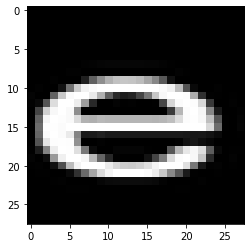

In [21]:
# Visualization of a digital font
img, label = get_input(train_loader_digital)
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

In [22]:
# Combine digital with other data
combined_train_digital_loader = combine_loaders(combined_train_loader, train_loader_digital)
combined_val_digital_loader = combine_loaders(combined_val_loader, val_loader_digital)
combined_test_digital_loader = combine_loaders(combined_test_loader, test_loader_digital)

Label: s


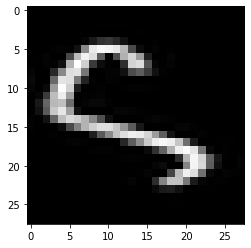

In [23]:
# Verifiying combined
img, label = get_input(combined_test_digital_loader)
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

In [24]:
# Train model with augmented data
model_digital = letterCNN(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_digital.parameters(), lr=1e-3)
train_network(model_digital, combined_train_digital_loader, combined_val_digital_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.15562
   Val loss: 0.76704

EPOCH 1
 Train loss: 0.68042
   Val loss: 0.58367

EPOCH 2
 Train loss: 0.55307
   Val loss: 0.51566

EPOCH 3
 Train loss: 0.48705
   Val loss: 0.50036

EPOCH 4
 Train loss: 0.44824
   Val loss: 0.46678

EPOCH 5
 Train loss: 0.41756
   Val loss: 0.46312

EPOCH 6
 Train loss: 0.39702
   Val loss: 0.45596

EPOCH 7
 Train loss: 0.37922
   Val loss: 0.43773

EPOCH 8
 Train loss: 0.36395
   Val loss: 0.41984

EPOCH 9
 Train loss: 0.35077
   Val loss: 0.41523



Test accuracy: 85.615


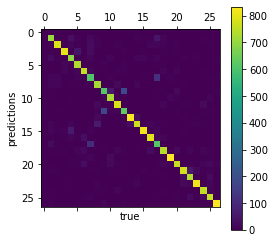

In [25]:
acc, true, pred = test_network(model_digital, combined_test_digital_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_digital.classes), pred, true)

The accuracy of the model with the augmented data did not improve (in fact, it decreased by about 0.4%). It is possible that this happened because we only included 100 fonts - we believe that including more fonts in our dataset should improve the accuracy of our model. However, given current results, it is reasonable to say that the improvement in accuracy will not be very significant even if more fonts are added. 

### 1b) Regularization through dropout

We hypothesize that adding dropout will decrease the accuracy of our model because each image is simply a 28 x 28 image of a letter, and dropping out even the smallest learned feature for a small image should impact the accuracy negatively.

In [26]:
class letterCNNDropout(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(1152, len(self.classes))
        )
            
    def forward(self, x):
        output = self.layers(x)
        return output

In [27]:
model_dropout = letterCNNDropout(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_dropout.parameters(), lr=1e-3)
train_network(model_dropout, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.17692
   Val loss: 0.81261

EPOCH 1
 Train loss: 0.70136
   Val loss: 0.61717

EPOCH 2
 Train loss: 0.58937
   Val loss: 0.56049

EPOCH 3
 Train loss: 0.53509
   Val loss: 0.53528

EPOCH 4
 Train loss: 0.50329
   Val loss: 0.51375

EPOCH 5
 Train loss: 0.48356
   Val loss: 0.50402

EPOCH 6
 Train loss: 0.46379
   Val loss: 0.50180

EPOCH 7
 Train loss: 0.45529
   Val loss: 0.48861

EPOCH 8
 Train loss: 0.43767
   Val loss: 0.48151

EPOCH 9
 Train loss: 0.42734
   Val loss: 0.47890



Test accuracy: 85.837


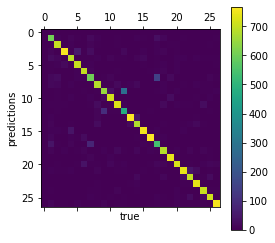

In [28]:
acc, true, pred = test_network(model_dropout, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_dropout.classes), pred, true)

As hypothesized, the accuracy of our model did drop using dropout.

### 1c) Regularization through Average Pooling

We hypothesize that the accuracy of our model will stay about the same with average pooling. We believe this to be the case because we have a network with just one convolutional layer which learns on fairly small images. 

Label: v


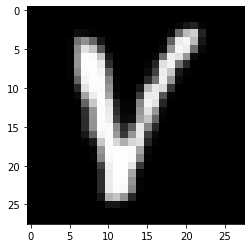

In [29]:
# Visualizing the combined dataset 
img, label = get_input(combined_train_loader)
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

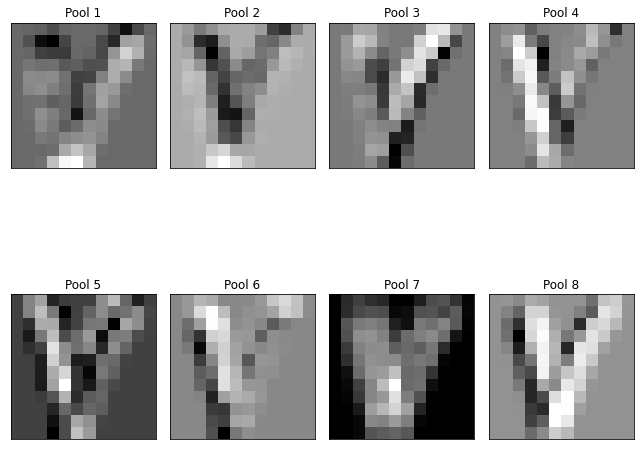

In [30]:
# visualize kernels with max pooling
conv_out = basic_model.layers[0](img)
_ = display_pool_outputs(basic_model.layers[1], conv_out)

We see that the kernels are a little blotchy. This is to be expected as a result of max pooling. The learned kernels with average pooling should be a little smoother. 

In [31]:
class letterCNNAvgPool(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.AvgPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, len(self.classes))
        )
            
    def forward(self, x):
        output = self.layers(x)
        return output

In [32]:
model_avgpool = letterCNNAvgPool(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_avgpool.parameters(), lr=1e-3)
train_network(model_avgpool, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.19618
   Val loss: 0.77711

EPOCH 1
 Train loss: 0.67344
   Val loss: 0.60708

EPOCH 2
 Train loss: 0.55692
   Val loss: 0.54158

EPOCH 3
 Train loss: 0.50077
   Val loss: 0.50566

EPOCH 4
 Train loss: 0.46430
   Val loss: 0.49255

EPOCH 5
 Train loss: 0.43916
   Val loss: 0.48162

EPOCH 6
 Train loss: 0.41883
   Val loss: 0.48486

EPOCH 7
 Train loss: 0.40211
   Val loss: 0.46610

EPOCH 8
 Train loss: 0.38852
   Val loss: 0.46919

EPOCH 9
 Train loss: 0.37544
   Val loss: 0.46369



Test accuracy: 86.338


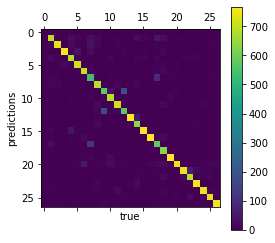

In [33]:
acc, true, pred = test_network(model_avgpool, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_avgpool.classes), pred, true)

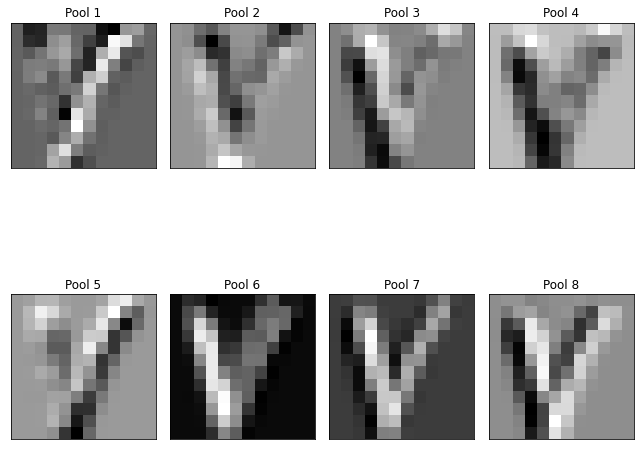

In [34]:
# visualize average pooling
conv_out = model_avgpool.layers[0](img)
_ = display_pool_outputs(model_avgpool.layers[1], conv_out)

The learned kernels for average pooling are smoother than the learned kernels for max pooling, as expected. As hypothesized, the accuracy of our model did not improve with average pooling. However, it is interesting that the accuracy decreased a bit with average pooling. This suggests that, for the task of letter recognition, max pooling is a better strategy than average pooling. 

### 1d) Regularization through Early Stopping

As our final experiment for the first computational experiment, we implement early stopping. We hypothesize that early stopping should improve the accuracy marginally. 

In [35]:
model_early_stopping = letterCNN(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_early_stopping.parameters(), lr=1e-3)
train_network(model_early_stopping, combined_train_loader, combined_val_loader, criterion, optimizer, early_stopping=True)

  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.13237
   Val loss: 0.73137

EPOCH 1
 Train loss: 0.63519
   Val loss: 0.55776

EPOCH 2
 Train loss: 0.50745
   Val loss: 0.48444

EPOCH 3
 Train loss: 0.45068
   Val loss: 0.45762

EPOCH 4
 Train loss: 0.41336
   Val loss: 0.43088

EPOCH 5
 Train loss: 0.38989
   Val loss: 0.44046

EPOCH 6
 Train loss: 0.37066
   Val loss: 0.42474

EPOCH 7
 Train loss: 0.35339
   Val loss: 0.41556

EPOCH 8
 Train loss: 0.34432
   Val loss: 0.41926

EPOCH 9
 Train loss: 0.32975
   Val loss: 0.41076

EPOCH 10
 Train loss: 0.31780
   Val loss: 0.40976

EPOCH 11
 Train loss: 0.30791
   Val loss: 0.41129

EPOCH 12
 Train loss: 0.29859
   Val loss: 0.41870

Early stopping in epoch 12.


Test accuracy: 87.264


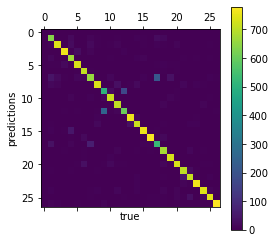

In [36]:
acc, true, pred = test_network(model_early_stopping, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_early_stopping.classes), pred, true)

The accuracy of our model with early stopping did not improve and stayed about the same. 

All these computational experiments show that, as defined, our `letterCNN` is actually well defined and supports a good amount of generalization. To get good results, then, we must pick the dataset carefully so that our model generalizes to a variety of handwriting and font styles. 

## Computational Experiment 2 - Architecture

As our second computational experiment, we will visualize the learned kernels of our basic model and then change the architecture to create a new model in hopes of creating a more accurate network. 

### Visualizing previous kernels

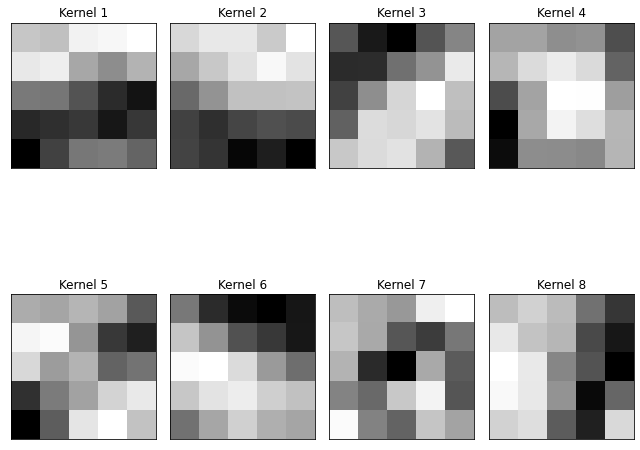

In [37]:
# extract the weights from the learned model
conv1wt = basic_model.layers[0].weight.data.numpy()
display_kernels(conv1wt)

It seems that in our basic model, the kernels are learning to identify specific edge types within letters. For example, in Kernel 3, it seems that the model is learning to identify horizontal edges while in Kernel 6 the model is learning to identify vertical edges. Based upon this, we hypothesize that adding a second convolutional layer to our current model will help it learn the features/characterisitics of each letter better.

### 2a) Double Convolutional Layer

In [38]:
class letterCNNDouble(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=64, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1024, len(self.classes))
        )
            
    def forward(self, x):
        return self.layers(x)

In [39]:
model_double_layer = letterCNNDouble(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_double_layer.parameters(), lr=1e-3)
train_network(model_double_layer, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.86158
   Val loss: 0.46905

EPOCH 1
 Train loss: 0.41622
   Val loss: 0.36951

EPOCH 2
 Train loss: 0.33177
   Val loss: 0.31937

EPOCH 3
 Train loss: 0.28326
   Val loss: 0.30946

EPOCH 4
 Train loss: 0.25036
   Val loss: 0.29349

EPOCH 5
 Train loss: 0.22554
   Val loss: 0.27256

EPOCH 6
 Train loss: 0.20587
   Val loss: 0.28167

EPOCH 7
 Train loss: 0.19041
   Val loss: 0.25751

EPOCH 8
 Train loss: 0.17546
   Val loss: 0.27948

EPOCH 9
 Train loss: 0.16105
   Val loss: 0.27606



Test accuracy: 91.539


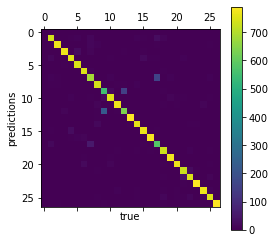

In [40]:
acc, true, pred = test_network(model_double_layer, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_double_layer.classes), pred, true)

As we can see, adding a seecond layer did indeed increase the accuracy by about 4% as per our hypothesis.

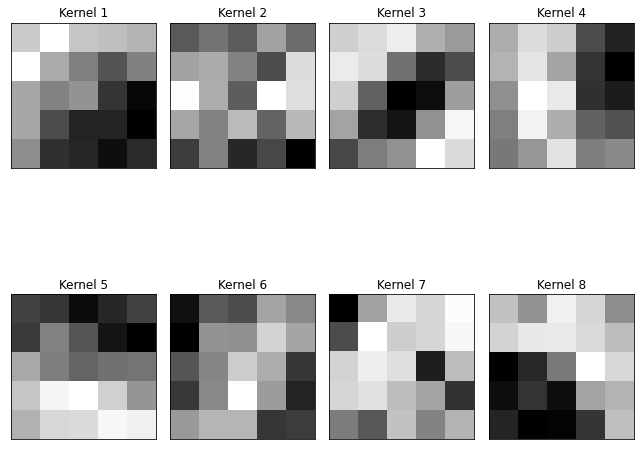

In [41]:
# extract the weights from the learned model
conv2wtsfirst = model_double_layer.layers[0].weight.data.numpy()
display_kernels(conv2wtsfirst)

The first layer is still learning the hard edges of each letter as the single convolutional layer network (i.e. our basic model).

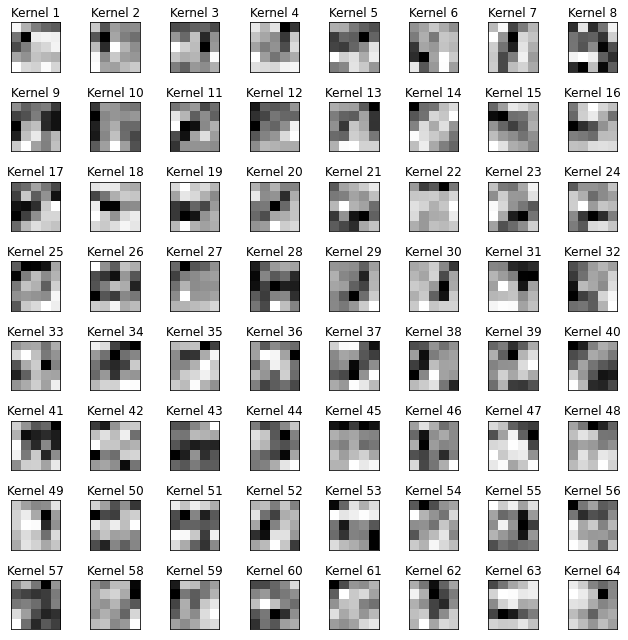

In [42]:
# extract the weights from the learned model
conv2wtssecond = model_double_layer.layers[3].weight.data.numpy()
display_kernels(conv2wtssecond)

The second layer seems to be learning more precise/specific features. It is quite obvious that the second layer's kernels are learning more precise features. It seems that the second layer is starting to learn more nuances between the edges of each letter - however, that is much harder to confirm. Still, as hypothesized, adding a second convolution layer to our basic CNN helped the new model learn more precise features about each letter and this in turn increased the accuracy of our new model. 

### 2b) Changing the Kernel Size

In [43]:
class letterCNNKernel(nn.Module):
    def __init__(self, classes, size):
        super().__init__()
        self.classes = classes
        output_size = (((28 - size) + 1) // 2) ** 2 * 8 
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(size,size), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(output_size, len(self.classes))
        )
            
    def forward(self, x):
        return self.layers(x)

Label: n


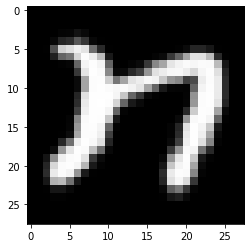

In [95]:
# Visualizing a different letter from the combined dataset
img, label = get_input(combined_train_loader)
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

#### Size 3 kernel

In [44]:
model_kernel_3 = letterCNNKernel(classes, 3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_kernel_3.parameters(), lr=1e-3)
train_network(model_kernel_3, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.27693
   Val loss: 0.97442

EPOCH 1
 Train loss: 0.87752
   Val loss: 0.79695

EPOCH 2
 Train loss: 0.74565
   Val loss: 0.71227

EPOCH 3
 Train loss: 0.66363
   Val loss: 0.65484

EPOCH 4
 Train loss: 0.59904
   Val loss: 0.59529

EPOCH 5
 Train loss: 0.54175
   Val loss: 0.55623

EPOCH 6
 Train loss: 0.49738
   Val loss: 0.52889

EPOCH 7
 Train loss: 0.45943
   Val loss: 0.50716

EPOCH 8
 Train loss: 0.43596
   Val loss: 0.48115

EPOCH 9
 Train loss: 0.41326
   Val loss: 0.48160



Test accuracy: 85.837


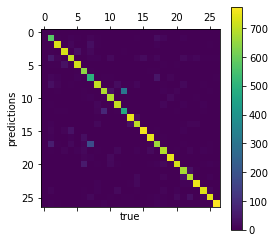

In [45]:
acc, true, pred = test_network(model_kernel_3, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_kernel_3.classes), pred, true)

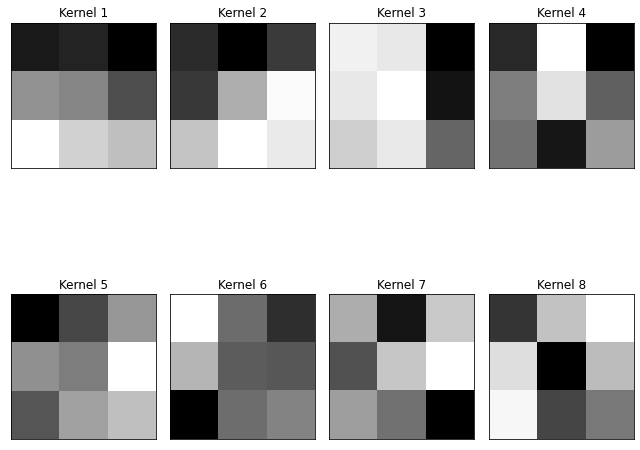

In [96]:
# extract the weights from the learned model
convk3_layer = model_kernel_3.layers[0]
display_kernels(convk3_layer.weight.data.numpy())

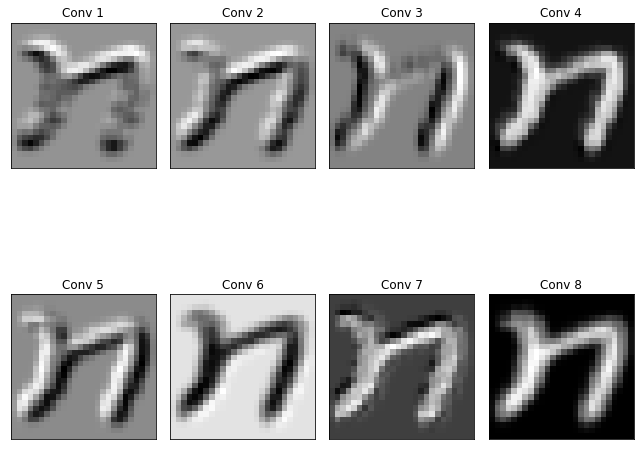

In [97]:
# Visualizing convolved outputs for 3x3 kernel
_ = display_conv_outputs(convk3_layer, img)

#### Size 8 kernel

In [47]:
model_kernel_8 = letterCNNKernel(classes, 8)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_kernel_8.parameters(), lr=1e-3)
train_network(model_kernel_8, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.07853
   Val loss: 0.68159

EPOCH 1
 Train loss: 0.58584
   Val loss: 0.53069

EPOCH 2
 Train loss: 0.48862
   Val loss: 0.50414

EPOCH 3
 Train loss: 0.44179
   Val loss: 0.44932

EPOCH 4
 Train loss: 0.41038
   Val loss: 0.42019

EPOCH 5
 Train loss: 0.38562
   Val loss: 0.40674

EPOCH 6
 Train loss: 0.36433
   Val loss: 0.42463

EPOCH 7
 Train loss: 0.34951
   Val loss: 0.39273

EPOCH 8
 Train loss: 0.33302
   Val loss: 0.38313

EPOCH 9
 Train loss: 0.32182
   Val loss: 0.40950



Test accuracy: 87.693


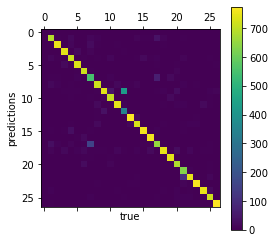

In [48]:
acc, true, pred = test_network(model_kernel_8, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_kernel_8.classes), pred, true)

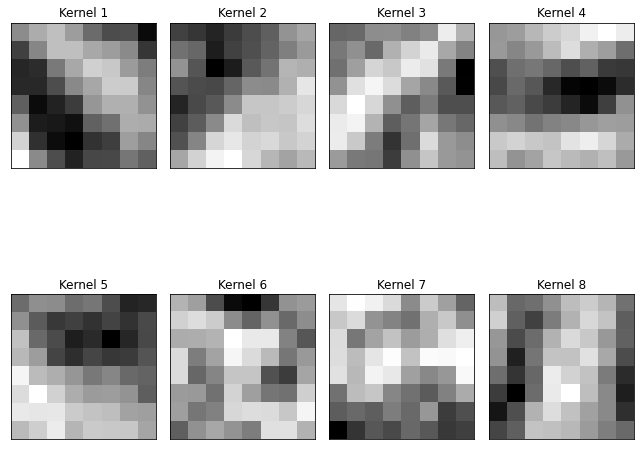

In [98]:
# extract the weights from the learned model
convk8_layer = model_kernel_8.layers[0]
display_kernels(convk8_layer.weight.data.numpy())

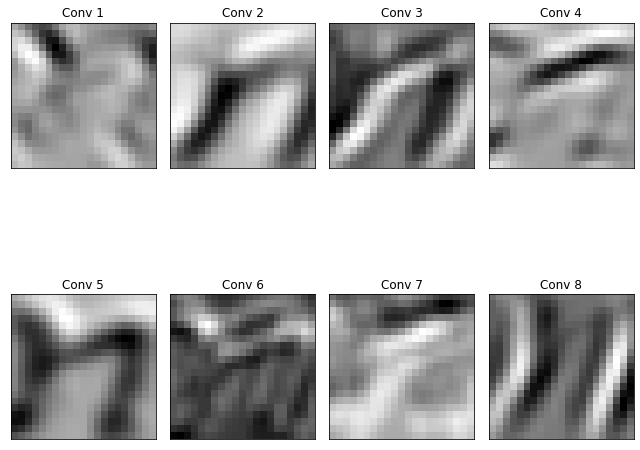

In [99]:
# Visualizing convolved outputs for 8x8 kernel
_ = display_conv_outputs(convk8_layer, img)

#### Size 11 kernel

In [50]:
model_kernel_11 = letterCNNKernel(classes, 11)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_kernel_11.parameters(), lr=1e-3)
train_network(model_kernel_11, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.08505
   Val loss: 0.67317

EPOCH 1
 Train loss: 0.58400
   Val loss: 0.50850

EPOCH 2
 Train loss: 0.48427
   Val loss: 0.46785

EPOCH 3
 Train loss: 0.43866
   Val loss: 0.43504

EPOCH 4
 Train loss: 0.40843
   Val loss: 0.43283

EPOCH 5
 Train loss: 0.38515
   Val loss: 0.42439

EPOCH 6
 Train loss: 0.36529
   Val loss: 0.40652

EPOCH 7
 Train loss: 0.35057
   Val loss: 0.40547

EPOCH 8
 Train loss: 0.33670
   Val loss: 0.39822

EPOCH 9
 Train loss: 0.32806
   Val loss: 0.39210



Test accuracy: 88.256


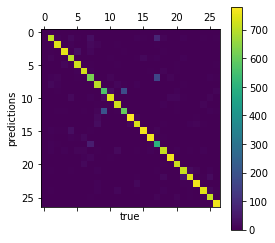

In [51]:
acc, true, pred = test_network(model_kernel_11, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_kernel_11.classes), pred, true)

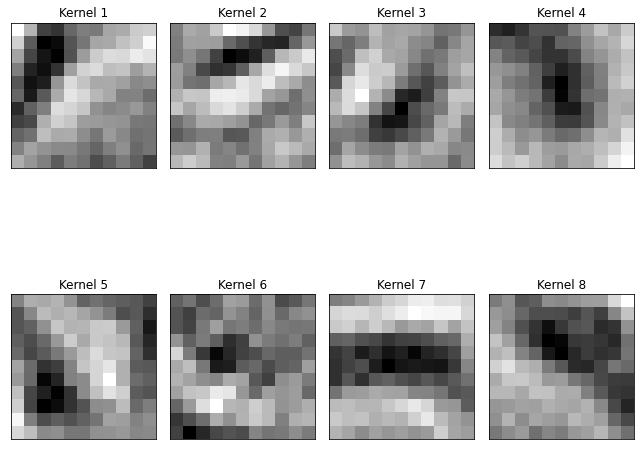

In [100]:
# extract the weights from the learned model
convk11_layer = model_kernel_11.layers[0]
display_kernels(convk11_layer.weight.data.numpy())

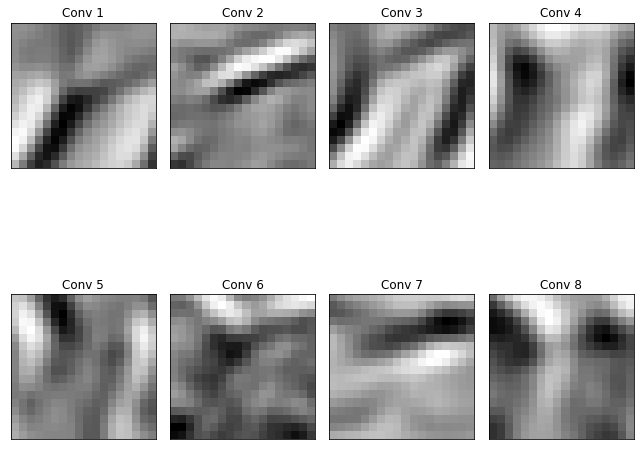

In [101]:
# Visualizing convolved outputs for 11x11 kernel
_ = display_conv_outputs(convk11_layer, img)

## Optimized Inputs

In [53]:
optimized_inputs_kernel_3 = get_optimized_inputs(model_kernel_3, nepochs=1000)
optimized_inputs_kernel_5 = get_optimized_inputs(basic_model, nepochs=1000)
optimized_inputs_kernel_8 = get_optimized_inputs(model_kernel_8, nepochs=1000)
optimized_inputs_kernel_11 = get_optimized_inputs(model_kernel_11, nepochs=1000)
optimized_inputs_double_conv = get_optimized_inputs(model_double_layer, nepochs=1000, validate_loss=True)

finished N/A with 0.20604 loss	Expected: N/A. Predicted: N/A.
finished a with 0.00029 loss	Expected: a. Predicted: a.
finished b with 0.00028 loss	Expected: b. Predicted: b.
finished c with 0.00016 loss	Expected: c. Predicted: c.
finished d with 0.00025 loss	Expected: d. Predicted: d.
finished e with 0.00028 loss	Expected: e. Predicted: e.
finished f with 0.00018 loss	Expected: f. Predicted: f.
finished g with 0.00029 loss	Expected: g. Predicted: g.
finished h with 0.00019 loss	Expected: h. Predicted: h.
finished i with 0.00008 loss	Expected: i. Predicted: i.
finished j with 0.00008 loss	Expected: j. Predicted: j.
finished k with 0.00023 loss	Expected: k. Predicted: k.
finished l with 0.00008 loss	Expected: l. Predicted: l.
finished m with 0.00013 loss	Expected: m. Predicted: m.
finished n with 0.00025 loss	Expected: n. Predicted: n.
finished o with 0.00044 loss	Expected: o. Predicted: o.
finished p with 0.00019 loss	Expected: p. Predicted: p.
finished q with 0.00010 loss	Expected: q. 

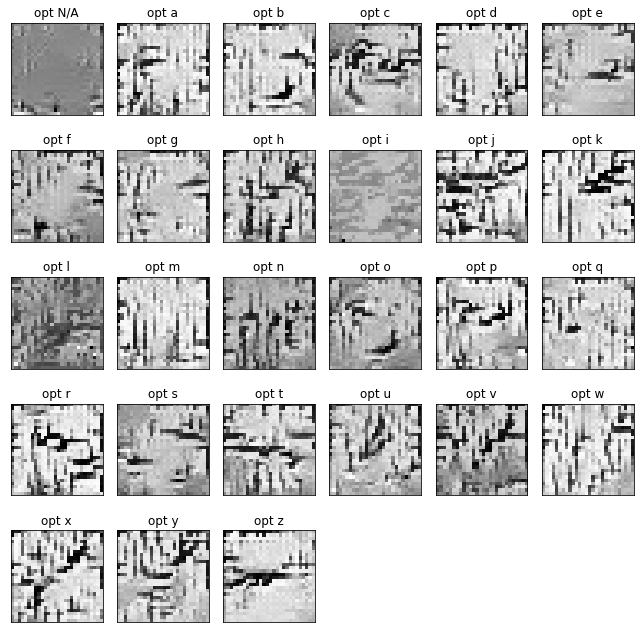

In [54]:
display_optimized_inputs(optimized_inputs_kernel_3)

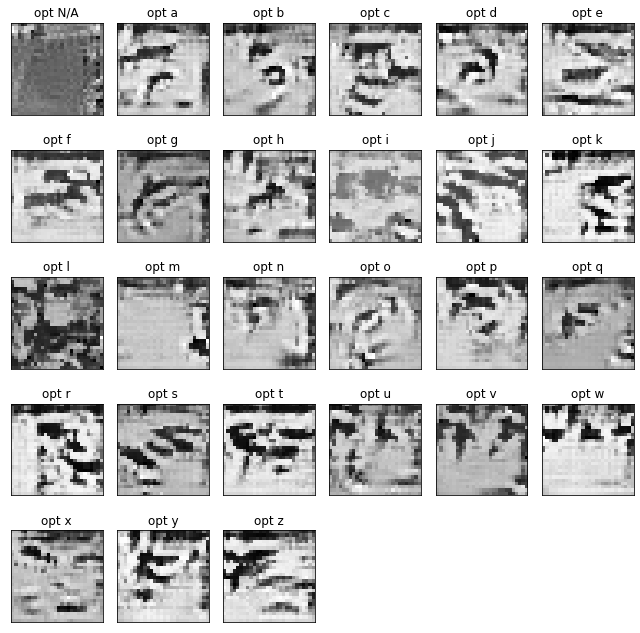

In [55]:
display_optimized_inputs(optimized_inputs_kernel_5)

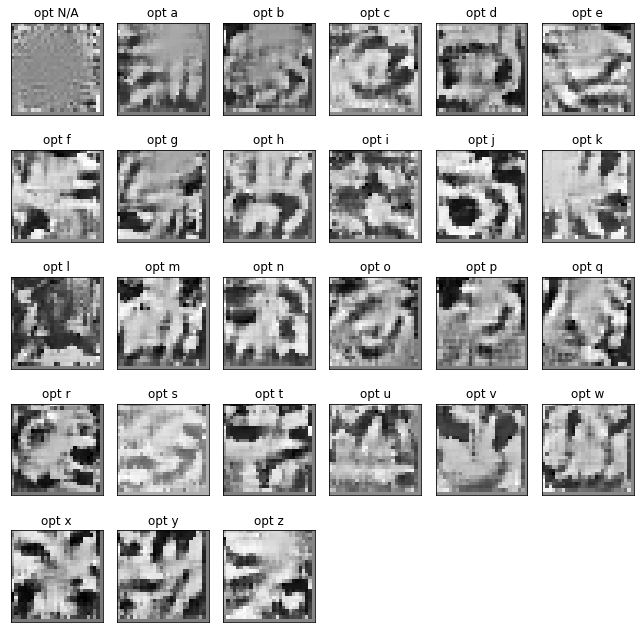

In [56]:
display_optimized_inputs(optimized_inputs_kernel_8)

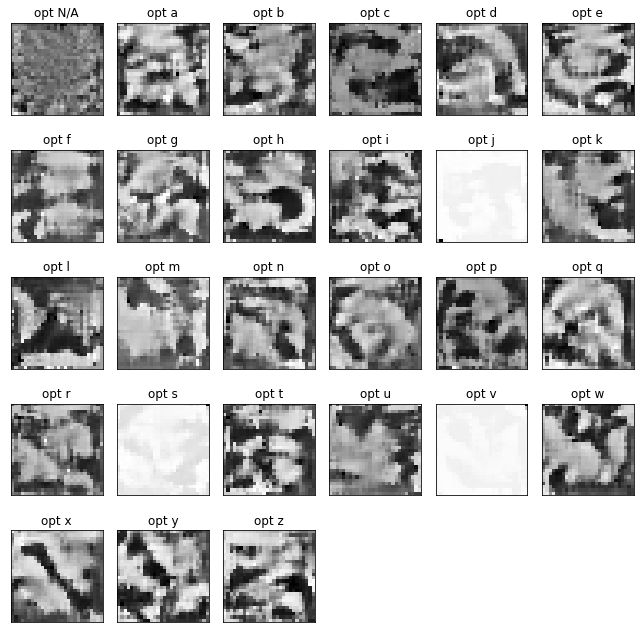

In [57]:
display_optimized_inputs(optimized_inputs_kernel_11)

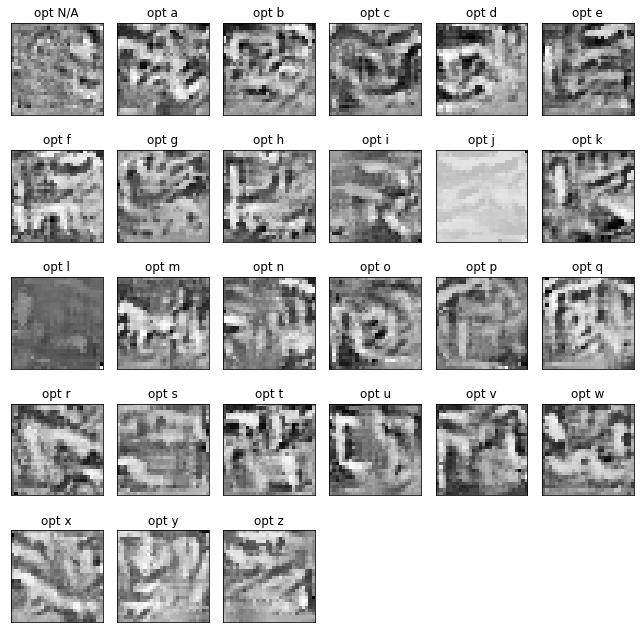

In [58]:
display_optimized_inputs(optimized_inputs_double_conv)

## Additional Visualizations

We provide some additional visualizations here for reference. 

Label: u


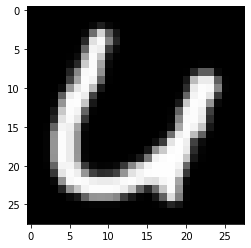

In [59]:
# Visualizing a different letter from the combined dataset
img, label = get_input(combined_train_loader)
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

#### Single Convolution Layer

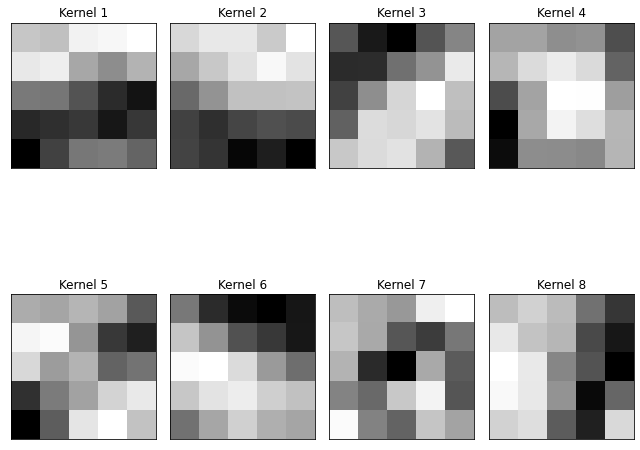

In [60]:
# Visualizing the learned kernels for the sinlge convolutional layer network
conv1_layer = basic_model.layers[0]
display_kernels(conv1_layer.weight.data.numpy())

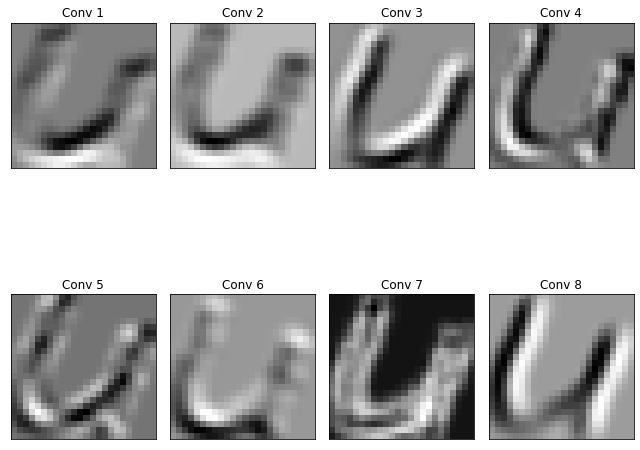

In [61]:
# Visualizing convolved outputs for the sinlge convolutional layer network
conv_outs = display_conv_outputs(conv1_layer, img)

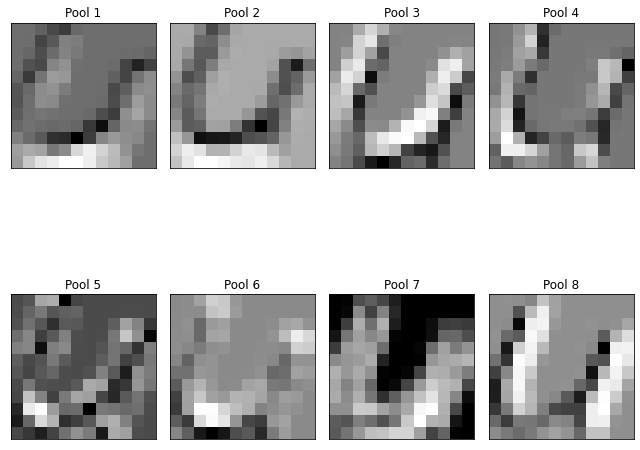

In [62]:
# Visualizing the max pooling layer outputs for the sinlge convolutional layer network
_ = display_pool_outputs(basic_model.layers[1], conv_outs)

#### Double Convolutional Layer

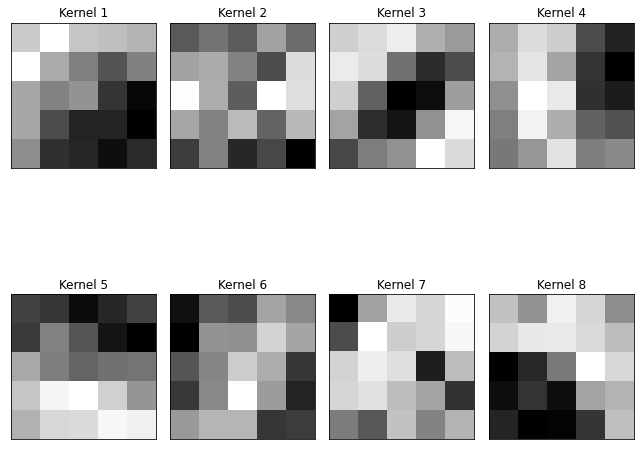

In [63]:
# Visualizing the learned kernels of the first convolution layer of the double covolutional network
conv2_layer1 = model_double_layer.layers[0]
display_kernels(conv2_layer1.weight.data.numpy())

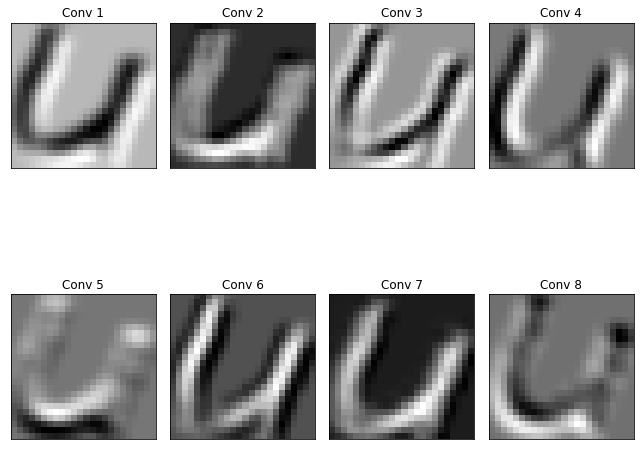

In [64]:
# Visualizing the convolved outputs of first convolution layer of the double covolutional network
outs_layer1 = display_conv_outputs(model_double_layer.layers[0], img)

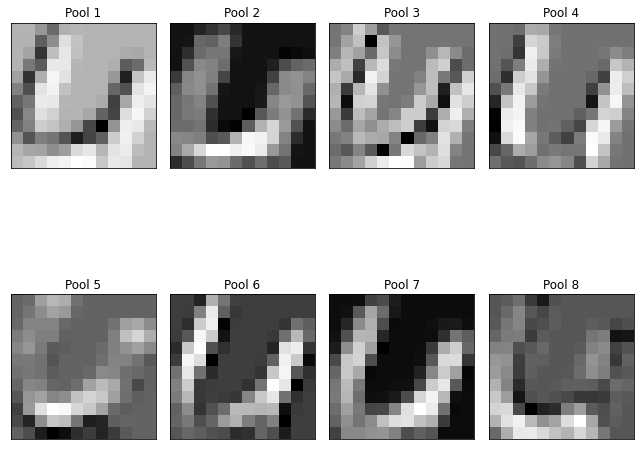

In [65]:
# Visualizing the max pool outputs of the first max pool layer of the double covolutional network
pooled_layer1 = display_pool_outputs(model_double_layer.layers[1], outs_layer1)

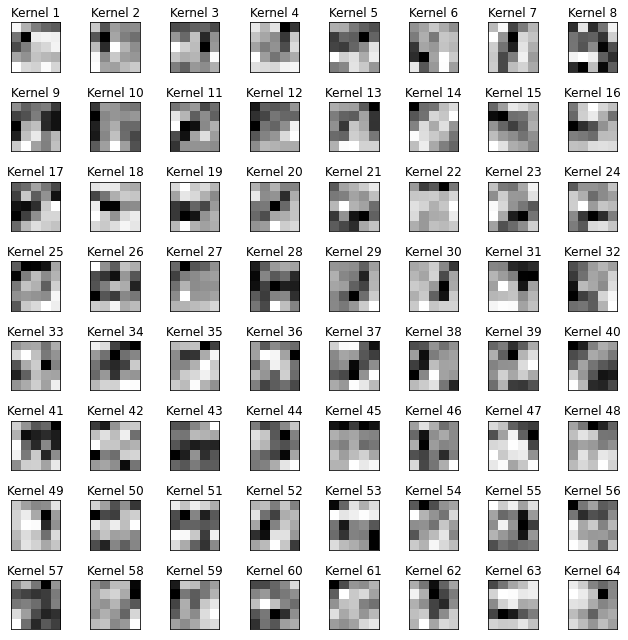

In [66]:
# Visualizing the learned kernels of the second convolution layer of the double covolutional network
conv2_layer2 = model_double_layer.layers[3]
display_kernels(conv2_layer2.weight.data.numpy())

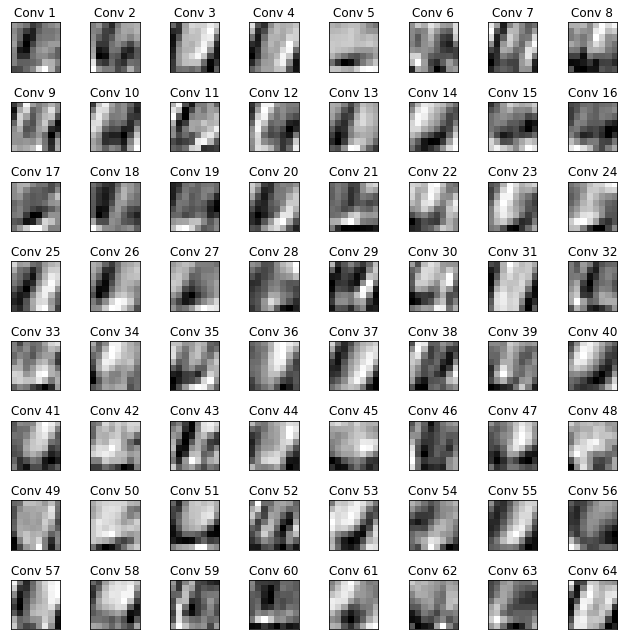

In [67]:
# Visualizing the convolved outputs of the second convolution layer of the double covolutional network
inputs_layer2 = model_double_layer.layers[2](pooled_layer1)
outs_layer2 = display_conv_outputs(model_double_layer.layers[3], inputs_layer2)

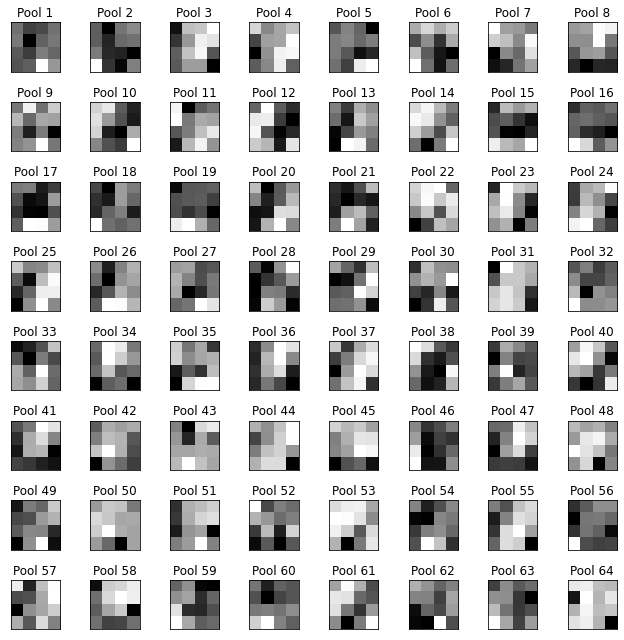

In [68]:
# Visualizing the max pool outputs of second max pool layer of the double covolutional network
_ = display_pool_outputs(model_double_layer.layers[4], outs_layer2)

# Fin